# Does amplicon bias help?
> Let's see if we should even keep this term

Using the experimental amplicon bias term introduced on Nov 29 2022

Last modified Oct 27, 2023

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from aptr.simulation_new import make_tables
from aptr.database import RnaDB
from aptr.torch_solver import TorchSolver

plt.rc("font", size=20)

In [3]:
rnadb = RnaDB(
    # path_to_dnaA = "../../data/allDnaA.tsv",
    # path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [17]:
# Copied from scaling_experiment_matrix.ipynb


def score(solver, true_abundances, true_log_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.R_hat.exp().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp(true_log_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances

In [18]:
# Experiment: How does the model perform with a bias term in the presence/absence of actual_bias?

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

results = pd.DataFrame(
    columns=[
        "scale",
        "simulation_bias",
        "model_bias",
        "genome",
        "sample",
        "ptr_true",
        "ptr_inferred",
        "ptr_score",
        "abundance_true",
        "abundance_inferred",
        "abundance_score",
    ]
)

for simulation_bias in [True, False]:
    for multiplier in range(-3, 3):
        scale = 10**multiplier
        print(f"Scale: {scale}")
        abundances, log_ptrs, otus = make_tables(db=rnadb, n_samples=20, n_genomes=10, sparsity=0, multiplier=scale)
        if simulation_bias:
            otus = otus.multiply(np.random.rand(otus.shape[0]), axis=0)

        for model_bias in [True, False]:
            solver = TorchSolver(otus=otus, db=rnadb)
            solver.train(lr=0.1, clip=True, model_bias=model_bias)
            ptr_score, abundance_score, inferred_ptrs, inferred_abundances = score(
                solver=solver, true_abundances=abundances, true_log_ptrs=log_ptrs
            )
            for i, genome_id in enumerate(solver.genome_ids):
                for j, sample_id in enumerate(solver.sample_ids):
                    try:
                        # results = results.append({
                        results.loc[len(results)] = {
                            "scale": scale,
                            "simulation_bias": simulation_bias,
                            "model_bias": model_bias,
                            "genome": genome_id,
                            "sample": sample_id,
                            "ptr_true": np.exp(log_ptrs.loc[genome_id, sample_id]),
                            "ptr_inferred": inferred_ptrs.loc[genome_id, sample_id],
                            "ptr_score": ptr_score.loc[genome_id, sample_id],
                            "abundance_true": abundances.loc[genome_id, sample_id],
                            "abundance_inferred": inferred_abundances.loc[genome_id, sample_id],
                            "abundance_score": abundance_score.loc[genome_id, sample_id],
                        }  # , ignore_index=True)
                    except KeyError:
                        print(f"==============KeyError: {genome_id}, {sample_id}")

Scale: 0.001
Using OTU index for md5s
Initial:	 0.9819512367248535
Epoch 0:	 0.27827274799346924
Epoch 1:	 0.27362823486328125
Epoch 2:	 0.2969779968261719
Epoch 3:	 0.2966134548187256
Epoch 4:	 0.29597559571266174
Epoch 5:	 0.2942942678928375
Epoch 6:	 0.3477032482624054
Epoch 7:	 0.34736183285713196
Using OTU index for md5s
Initial:	 0.9819512367248535
Epoch 0:	 0.2747090458869934
Epoch 1:	 0.2747090458869934
Epoch 2:	 0.3142090439796448
Epoch 3:	 0.3141702711582184
Epoch 4:	 0.3141048848628998
Epoch 5:	 0.31399309635162354
Epoch 6:	 0.3138103485107422
Scale: 0.01
Using OTU index for md5s
Initial:	 0.8116986155509949
Epoch 0:	 -0.24263647198677063
Epoch 1:	 -0.2432180643081665
Epoch 2:	 -0.24344618618488312
Epoch 3:	 -0.24361652135849
Epoch 4:	 -0.2138400375843048
Epoch 5:	 -0.21511492133140564
Epoch 6:	 -0.21512164175510406
Epoch 7:	 -0.21513919532299042
Epoch 8:	 -0.2151716947555542
Epoch 9:	 -0.21520274877548218
Using OTU index for md5s
Initial:	 0.8116986155509949
Epoch 0:	 -0.05

In [19]:
results.to_csv("../../data/figures/amplicon_bias_term.tsv", index=False, sep="\t")

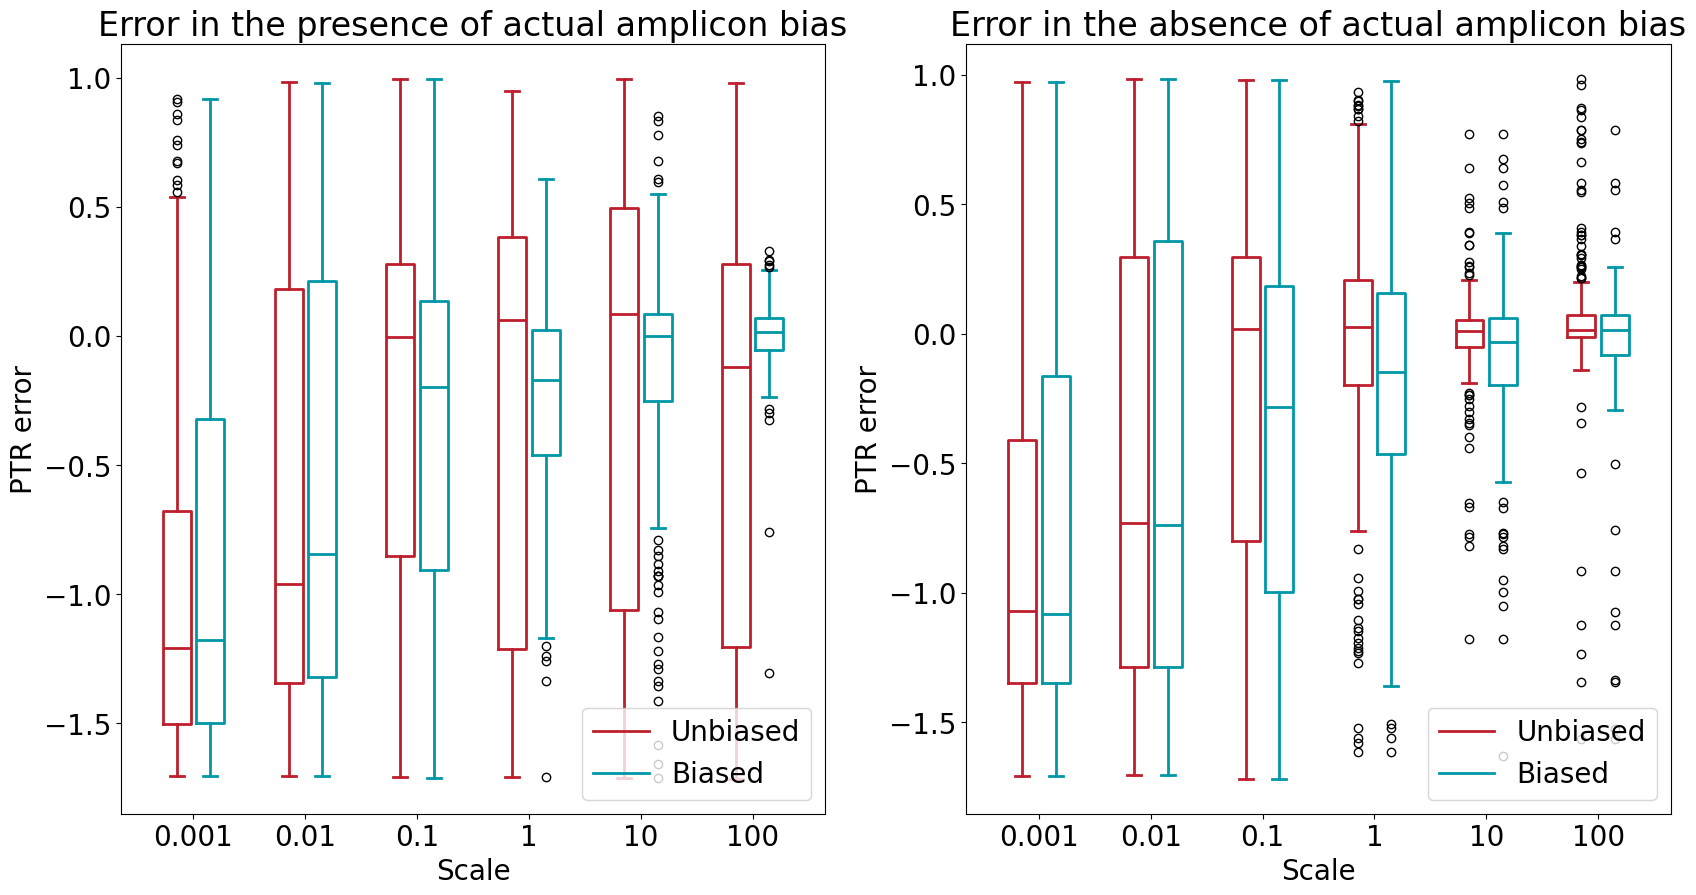

In [20]:
# fig = plt.figure(figsize=(15, 10))
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Make data
for ax, simulation_bias in zip(axs, [True, False]):
    results_filtered = results[results["simulation_bias"] == simulation_bias]
    for_boxplot_unbiased = results_filtered[results_filtered["model_bias"] == False]
    for_boxplot_bias = results_filtered[results_filtered["model_bias"] == True]
    x1 = [for_boxplot_unbiased[for_boxplot_unbiased["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
    x2 = [for_boxplot_bias[for_boxplot_bias["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

    # Plot
    bp1 = ax.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
    bp2 = ax.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
    ax.set_xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
    ax.set_xlabel("Scale")
    ax.set_ylabel("PTR error")

    # Change colors for medians
    for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
        for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
            for x in b[prop]:
                x.set(color=c, linewidth=2)

    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Unbiased", "Biased"], loc="lower right")
    pres_abs = "presence" if simulation_bias else "absence"
    ax.set_title(f"Error in the {pres_abs} of actual amplicon bias")